In [ ]:
%pip install matplotlib==3.8.1

In [ ]:
%pip install scikit-learn==1.3.2

In [ ]:
%pip install azure-storage-blob==12.18.3

In [2]:
from dotenv import load_dotenv
from pathlib import Path
import os

In [3]:
load_dotenv()

True

In [4]:
from azure.core.credentials import AzureKeyCredential
from azure.ai.formrecognizer import DocumentAnalysisClient

In [5]:
endpoint = os.getenv("FORM_RECOGNIZER_ENDPOINT")
key = os.getenv("FORM_RECOGNIZER_KEY")
model_id =  os.getenv("FORM_RECOGNIZER_MODEL_ID")
credential = AzureKeyCredential(key)
document_analysis_client = DocumentAnalysisClient(endpoint, credential)

In [6]:
from azure.storage.blob import BlobServiceClient, generate_blob_sas, BlobProperties
from azure.core.paging import ItemPaged

In [7]:
storage_url = os.getenv("STORAGE_ACCOUNT_ENDPOINT")
storage_key = os.getenv("STORAGE_ACCOUNT_KEY")
blob_service_client = BlobServiceClient(account_url=storage_url, credential=storage_key)

In [8]:
container_client = blob_service_client.get_container_client(os.getenv("STORAGE_ACCOUNT_CONTAINER"))

In [9]:
test_files: ItemPaged[BlobProperties] = container_client.list_blobs()

In [10]:
def get_type_from_pages(documents):
    type_count = {}
    for document in documents:
        if document.doc_type in type_count:
            type_count[document.doc_type] += 1
        else:
            type_count[document.doc_type] = 1
    "Get the most common type"
    return max(type_count, key=type_count.get)

In [30]:
from concurrent.futures import ThreadPoolExecutor
import concurrent.futures

results = []
def process_document(test_file):
    file_path = os.getenv("STORAGE_ACCOUNT_ENDPOINT") + os.getenv("STORAGE_ACCOUNT_CONTAINER") + "/" + test_file.name
    url =file_path
    poller = document_analysis_client.begin_classify_document_from_url(classifier_id= model_id, document_url=url)
    result = poller.result()
    pages = result.documents
    most_common_type = get_type_from_pages(pages)
    analyzed_file = {"file":test_file.name, "predicted_type": most_common_type,"real_type": test_file.name.split("/")[0]}
    print(analyzed_file)
    return analyzed_file

"Run in threads using ThreadPoolExecutor to reduce execution time, 14 is the default form recognizer parallelism"
with ThreadPoolExecutor(max_workers=14) as executor:
    future_to_type = {executor.submit(process_document, test_file): test_file for test_file in test_files} 
    for future in concurrent.futures.as_completed(future_to_type):
        results.append(future.result())


{'file': 'email/doc_000046.png', 'predicted_type': 'email', 'real_type': 'email'}
{'file': 'email/doc_000079.png', 'predicted_type': 'email', 'real_type': 'email'}
{'file': 'email/doc_000148.png', 'predicted_type': 'email', 'real_type': 'email'}
{'file': 'email/doc_000133.png', 'predicted_type': 'email', 'real_type': 'email'}
{'file': 'email/doc_000115.png', 'predicted_type': 'email', 'real_type': 'email'}
{'file': 'email/doc_000165.png', 'predicted_type': 'email', 'real_type': 'email'}
{'file': 'email/doc_000111.png', 'predicted_type': 'email', 'real_type': 'email'}
{'file': 'email/doc_000076.png', 'predicted_type': 'email', 'real_type': 'email'}
{'file': 'email/doc_000042.png', 'predicted_type': 'email', 'real_type': 'email'}
{'file': 'email/doc_000142.png', 'predicted_type': 'email', 'real_type': 'email'}
{'file': 'email/doc_000255.png', 'predicted_type': 'email', 'real_type': 'email'}
{'file': 'email/doc_000195.png', 'predicted_type': 'email', 'real_type': 'email'}
{'file': 'email/

In [31]:
results

[{'file': 'email/doc_000046.png',
  'predicted_type': 'email',
  'real_type': 'email'},
 {'file': 'email/doc_000079.png',
  'predicted_type': 'email',
  'real_type': 'email'},
 {'file': 'email/doc_000148.png',
  'predicted_type': 'email',
  'real_type': 'email'},
 {'file': 'email/doc_000133.png',
  'predicted_type': 'email',
  'real_type': 'email'},
 {'file': 'email/doc_000115.png',
  'predicted_type': 'email',
  'real_type': 'email'},
 {'file': 'email/doc_000165.png',
  'predicted_type': 'email',
  'real_type': 'email'},
 {'file': 'email/doc_000111.png',
  'predicted_type': 'email',
  'real_type': 'email'},
 {'file': 'email/doc_000076.png',
  'predicted_type': 'email',
  'real_type': 'email'},
 {'file': 'email/doc_000042.png',
  'predicted_type': 'email',
  'real_type': 'email'},
 {'file': 'email/doc_000142.png',
  'predicted_type': 'email',
  'real_type': 'email'},
 {'file': 'email/doc_000255.png',
  'predicted_type': 'email',
  'real_type': 'email'},
 {'file': 'email/doc_000195.png'

In [12]:
import pandas as pd

In [33]:

df = pd.DataFrame(results)
df.to_csv("results.csv",header=True, index=False)

In [14]:
df = pd.read_csv("results.csv",header=0)
df

,file,predicted_type,real_type
0,email/doc_000046.png,email,email
1,email/doc_000079.png,email,email
2,email/doc_000148.png,email,email
3,email/doc_000133.png,email,email
4,email/doc_000115.png,email,email
...,...,...,...
130,scientific_publication/doc_000698.png,resume,scientific_publication
131,scientific_publication/doc_000741.png,scientific_publication,scientific_publication
132,scientific_publication/doc_000756.png,scientific_publication,scientific_publication
133,scientific_publication/doc_000766.png,scientific_publication,scientific_publication


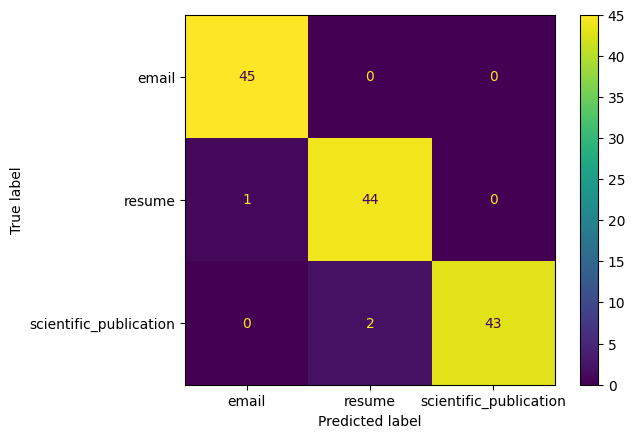

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions( df["real_type"], df["predicted_type"])
plt.show()

In [18]:
from sklearn.metrics import classification_report

In [19]:
print(classification_report(df["real_type"], df["predicted_type"]))

                        precision    recall  f1-score   support

                 email       0.98      1.00      0.99        45
                resume       0.96      0.98      0.97        45
scientific_publication       1.00      0.96      0.98        45

              accuracy                           0.98       135
             macro avg       0.98      0.98      0.98       135
          weighted avg       0.98      0.98      0.98       135



In [29]:
%%cmd
conda env export  > environment.yml

Microsoft Windows [Version 10.0.22621.2428]
(c) Microsoft Corporation. All rights reserved.

(adbapi) c:\Users\selopez\Repos\ClassifyDocs>conda env export  > environment.yml



(adbapi) c:\Users\selopez\Repos\ClassifyDocs>